# Predicting Heart Disease in Patients Using Classification

### Introduction:

Heart disease, also known as cardiovascular disease, refers to conditions which affect the heart, the most common of these conditions being coronary artery disease. Heart disease can lead to heart attacks, heart failure, arrhythmias and heart valve diseases. Some risk factors include high blood pressure, high cholesterol, obesity, and a sedentary lifestyle.

The question we attempt to answer is, "Can we predict the severity of heart disease, if any, in a patient based on their age, pain type, cholesterol, max heart rate, exercise induced angina, and gender?".

To answer this, the chosen data set is the “Heart Disease” dataset. Each observation contains details about an individual. It contains 14 variables with different attributes relating to heart disease, including an assigned value of 1-4 regarding the presence of heart disease in the individual.


### Methods

We will be conducting a classification analysis on the heart disease dataset with the goal of predicting the severity of heart disease (represented by the "severity" variable)

__Data Processing__
* Clean and wrangle the dataset.
* Filter the dataset to include only data from Cleveland in the  "region" column.
* Rename the "num" column to "severity."
* Select the following predictor columns: "severity," "age," "pain_type," "chol," "max_hr," "exang," "resting_ecg," and "sex."

__Data Splitting__
* Split the dataset into training and testing datasets. The training data will be used to train the model, while the testing data will be used to evaluate its performance.

__Model Building__
* Create a classification model based on the chosen specifications.
* Fit the model using the training data, allowing it to learn from the selected input features and class labels.

__Model Evaluation__
* Evaluate the model's performance using various evaluation metrics, such as accuracy precision and recall

__Model Tuning__
* We finally then fine tune the model to optimize its performance

__Describe at least one way that you will visualize the results__

* After evaluating and tuning the model we will often want to know which number of neighbors gives the best accuracy, we can create a visualization of that by plotting the accuracy against K values using a geom_point + geom_line graph. 


### Cleaning, Wrangling, Summary:

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Rows: 920 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): sex, dataset, cp, restecg, slope, thal
dbl (8): id, age, trestbps, chol, thalch, oldpeak, ca, num
lgl (2): fbs, exang

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,63,Male,Cleveland,typical angina,145,233,TRUE,lv hypertrophy,150,FALSE,2.3,downsloping,0,fixed defect,0
2,67,Male,Cleveland,asymptomatic,160,286,FALSE,lv hypertrophy,108,TRUE,1.5,flat,3,normal,2
3,67,Male,Cleveland,asymptomatic,120,229,FALSE,lv hypertrophy,129,TRUE,2.6,flat,2,reversable defect,1
4,37,Male,Cleveland,non-anginal,130,250,FALSE,normal,187,FALSE,3.5,downsloping,0,normal,0
5,41,Female,Cleveland,atypical angina,130,204,FALSE,lv hypertrophy,172,FALSE,1.4,upsloping,0,normal,0
6,56,Male,Cleveland,atypical angina,120,236,FALSE,normal,178,FALSE,0.8,upsloping,0,normal,0


`summarise()` has grouped output by 'severity'. You can override using the
`.groups` argument.


severity,pain_type,n,percent
<fct>,<chr>,<int>,<dbl>
0,asymptomatic,31,13.7168142
0,atypical angina,29,12.8318584
0,non-anginal,52,23.0088496
0,typical angina,11,4.8672566
1,asymptomatic,29,12.8318584
1,atypical angina,3,1.3274336
1,non-anginal,6,2.6548673
1,typical angina,4,1.7699115
2,asymptomatic,21,9.2920354


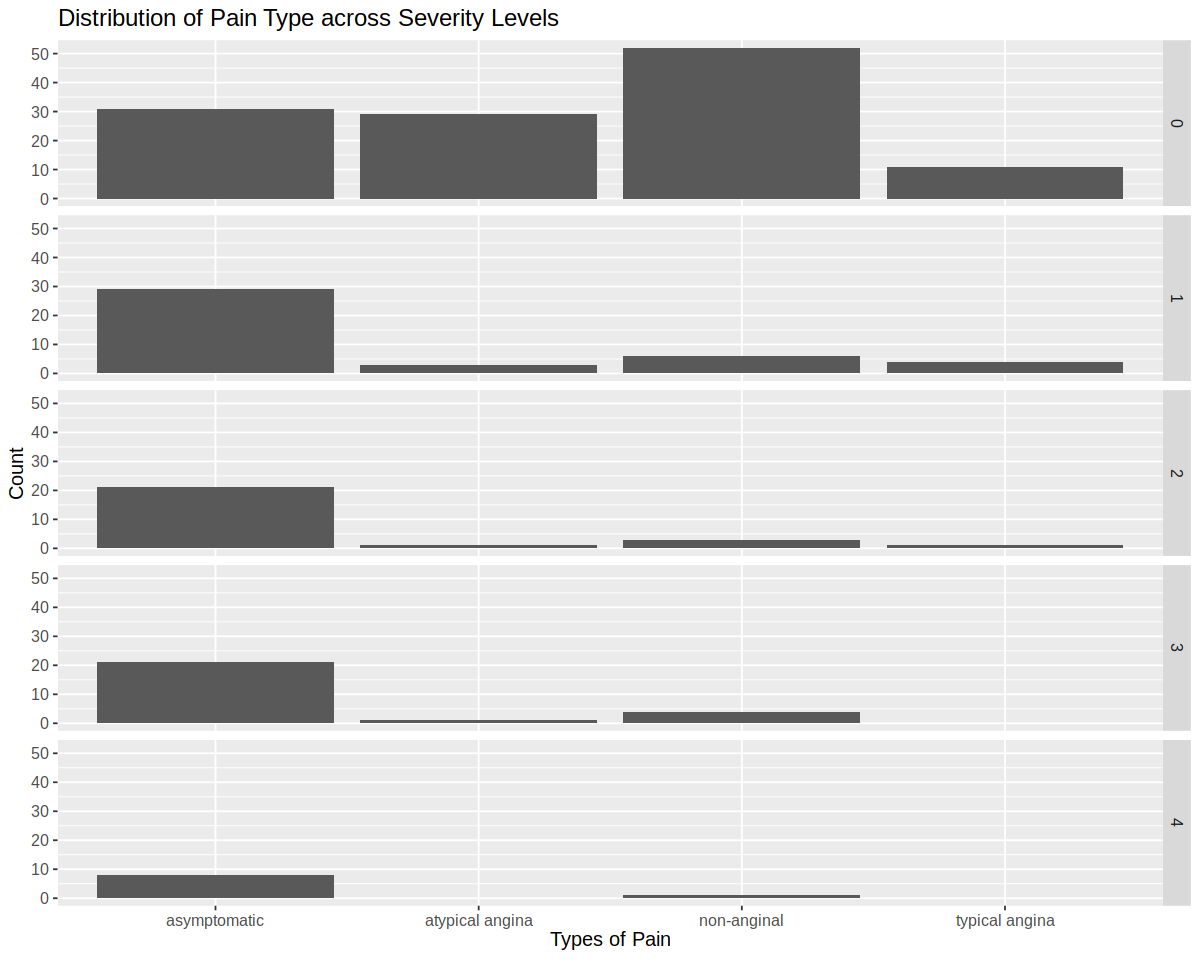

In [5]:
#Load all libraries and set plot dimensions
options(repr.plot.height = 8, repr.plot.width = 10)
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
install.packages("kknn")

#Load data frame and rename columns
urlfile= "https://raw.githubusercontent.com/cocom250/DSCI-100-Group-17/main/heart_disease_uci.csv"
heart_disease_data <- read_csv(url(urlfile))
head(heart_disease_data)

heart_disease_data <- rename(heart_disease_data, 
                             region = dataset,
                             pain_type = cp,
                             resting_bps = trestbps,
                             fasting_bs = fbs,
                             resting_ecg = restecg,
                             max_hr = thalch,
                             n_major_vessel = ca,
                             severity = num) 

#Cleaning up data, filtering for Cleveland and selecting predictor columns
heart_disease_data <- filter(heart_disease_data, region == "Cleveland") |>
    mutate(severity = as.factor(severity)) |>
    select(severity, age, pain_type, chol, max_hr, exang, resting_ecg, sex)


#Plot indicating the number and proportion of observations with each pain type for different severity level
pain_type_distribution <- heart_disease_train|>
    group_by(severity, pain_type) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(heart_disease_train))

pain_type_distribution

#Visualization of Pain Type distribution across severity levels
pain_type_distribution_plot <- ggplot(pain_type_distribution, 
                                 aes(x= pain_type, y =n)) +
    geom_bar(stat ="identity") +
    labs(x = "Types of Pain", y = "Count")+
    theme(text = element_text(size =12)) +
    facet_grid(rows = vars(severity)) +
    ggtitle("Distribution of Pain Type across Severity Levels")

pain_type_distribution_plot


In [6]:
# set the seed so our evaluation is reproducable 
set.seed(2024)

#Split the data into training set and testing set
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = severity)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

#Plot indicating the number and proportion of observations in each severity level & average age and cholestrol measures
severity_stats <- heart_disease_train |>
    group_by(severity) |>
    summarize(n = n(), age_avg = mean(age, na.rm = TRUE), chol_avg = mean(chol, na.rm = TRUE)) |>
    mutate(percent = 100*n/nrow(heart_disease_train))

severity_stats

severity,n,age_avg,chol_avg,percent
<fct>,<int>,<dbl>,<dbl>,<dbl>
0,123,52.23577,242.6179,54.424779
1,42,55.80952,252.4762,18.584071
2,26,58.07692,261.6538,11.504425
3,26,56.42308,246.6923,11.504425
4,9,60.77778,256.0000,3.982301


In [7]:
# set the seed so our evaluation is reproducable
set.seed(2024)

heart_recipe <- recipe(severity ~ age + chol + max_hr, data = heart_disease_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# training the classifier
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_disease_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4955752
Best kernel: rectangular
Best k: 3

In [9]:
# set the seed so our evaluation is reproducable
set.seed(2024)

#predicting labels in the test set 
heart_test_predictions <- predict(knn_fit, heart_disease_test) |>
    bind_cols(heart_disease_test)

heart_test_predictions

# evaluating performance of the classifier on the test set
heart_test_predictions |>
    metrics(truth = severity, estimate = .pred_class) |>
    filter(.metric == "accuracy")

# looking at the confusion matrix
confusion <- heart_test_predictions |>
    conf_mat(truth = severity, estimate = .pred_class)

confusion

.pred_class,severity,age,pain_type,chol,max_hr,exang,resting_ecg,sex
<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<chr>
1,0,56,atypical angina,236,178,FALSE,normal,Male
0,1,53,asymptomatic,203,155,TRUE,lv hypertrophy,Male
0,0,56,atypical angina,294,153,FALSE,lv hypertrophy,Female
0,0,52,non-anginal,199,162,FALSE,normal,Male
0,1,48,atypical angina,229,168,FALSE,normal,Male
1,0,58,typical angina,283,162,FALSE,lv hypertrophy,Female
0,0,58,non-anginal,340,172,FALSE,normal,Female
0,2,60,asymptomatic,230,160,TRUE,normal,Male
0,0,42,asymptomatic,226,178,FALSE,normal,Male


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4871795


          Truth
Prediction  0  1  2  3  4
         0 33  9  5  3  2
         1  5  1  1  1  0
         2  4  1  2  2  1
         3  0  1  2  2  1
         4  0  1  0  1  0

## accuracy prediction recall

calculate for accuracy etc.


In [18]:
# set the seed so our evaluation is reproducable
set.seed(2024)

# create the 25/75 split of the training data into training and validation
heart_split <- initial_split(heart_disease_train, prop = 0.75, strata = severity)
heart_subtrain <- training(heart_split)
heart_validation <- testing(heart_split)

# recreate the standardization recipe from before 
# (since it must be based on the training data)
heart_train_recipe <- recipe(severity ~age + chol + max_hr, data = heart_subtrain) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# fit the knn model (we can reuse the old knn_spec model from before)
knn_train_fit <- workflow() |>
  add_recipe(heart_train_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_subtrain)

# get predictions on the validation data
validation_predicted <- predict(knn_train_fit, heart_validation) |>
  bind_cols(heart_validation)

# compute the accuracy
acc <- validation_predicted |>
  metrics(truth = severity, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()

acc

# perform v fold, v=5
heart_vfold <- vfold_cv(heart_disease_train, v = 5, strata = severity)


#recreate standardization recipe using training data
heart_train_recipe <- recipe(severity ~age + chol + max_hr,
                        data = heart_disease_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# resampling
knn_fit_1 <- workflow() |>
    add_recipe(heart_train_recipe) |>
    add_model(knn_spec) |>
    fit_resamples(resamples = heart_vfold)


knn_fit_1 |>
    collect_metrics()

## !!! Look at accuracy and if we need to perform fold with different v


[1] 0.4912281

! Fold2: internal:
  There was 1 warning in `dplyr::summarise()`.
  ℹ In argument: `.estimate = metric_fn(...)`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.



.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,multiclass,0.4466868,5,0.01038022,Preprocessor1_Model1
roc_auc,hand_till,0.5931568,5,0.01411214,Preprocessor1_Model1


! Fold2: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 19 ...



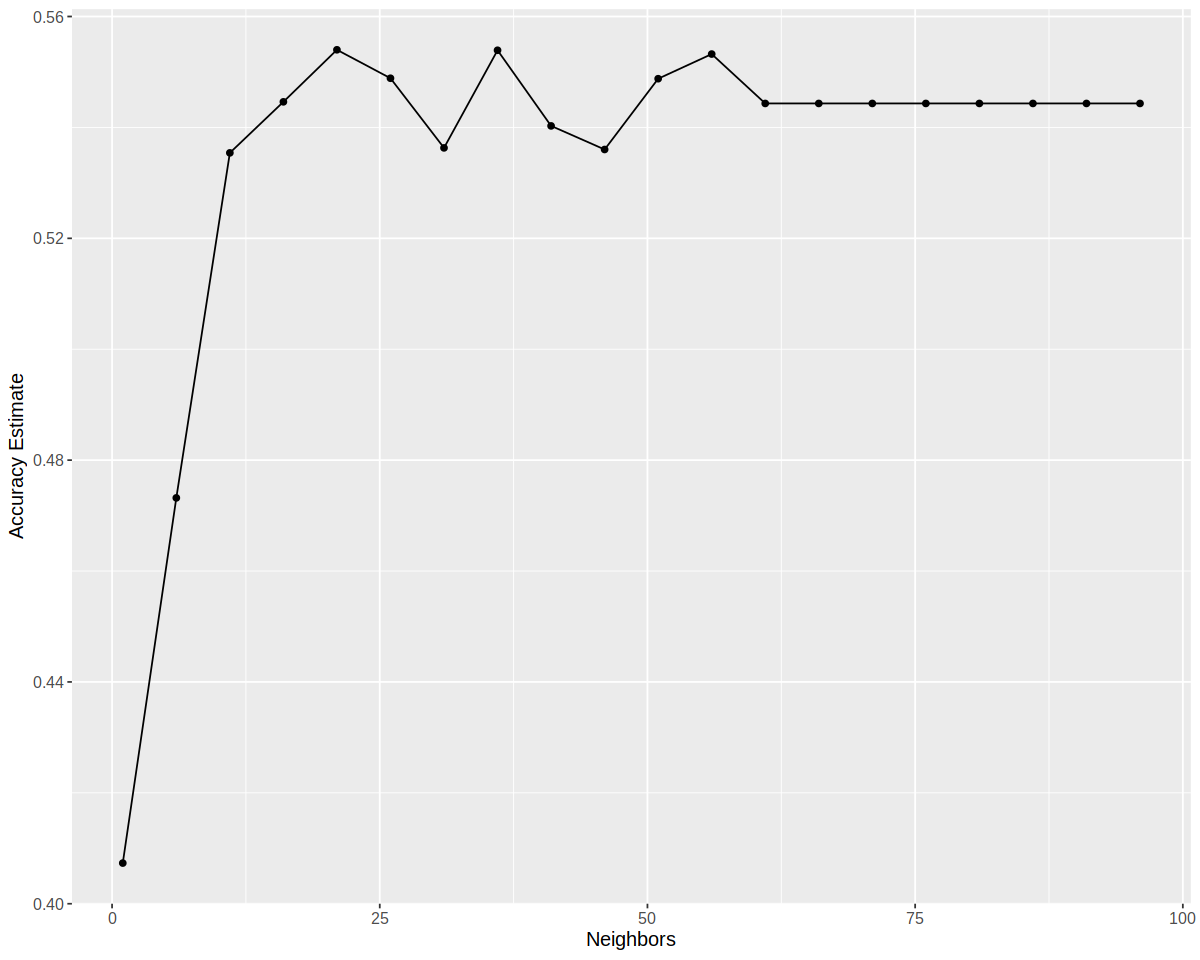

In [21]:
# set the seed so our evaluation is reproducable
set.seed(2024)

# parameter value selection
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")


# visualizing most accurate k value
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k
#based on the graph, k=21 seems to provide the highest accuracy

In [22]:
#using optimal k value = 21
# set the seed so our evaluation is reproducable
set.seed(2024)

heart_recipe <- recipe(severity ~ age + chol + max_hr, data = heart_disease_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# training the classifier
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_disease_train)

knn_fit

#predicting labels in the test set 
heart_test_predictions <- predict(knn_fit, heart_disease_test) |>
    bind_cols(heart_disease_test)

heart_test_predictions

# evaluating performance of the classifier on the test set
heart_test_predictions |>
    metrics(truth = severity, estimate = .pred_class) |>
    filter(.metric == "accuracy")

# looking at the confusion matrix
confusion <- heart_test_predictions |>
    conf_mat(truth = severity, estimate = .pred_class)

confusion


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(21,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4778761
Best kernel: rectangular
Best k: 21

.pred_class,severity,age,pain_type,chol,max_hr,exang,resting_ecg,sex
<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<chr>
0,0,56,atypical angina,236,178,FALSE,normal,Male
0,1,53,asymptomatic,203,155,TRUE,lv hypertrophy,Male
0,0,56,atypical angina,294,153,FALSE,lv hypertrophy,Female
0,0,52,non-anginal,199,162,FALSE,normal,Male
0,1,48,atypical angina,229,168,FALSE,normal,Male
0,0,58,typical angina,283,162,FALSE,lv hypertrophy,Female
0,0,58,non-anginal,340,172,FALSE,normal,Female
0,2,60,asymptomatic,230,160,TRUE,normal,Male
0,0,42,asymptomatic,226,178,FALSE,normal,Male


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5128205


          Truth
Prediction  0  1  2  3  4
         0 39 12  5  8  4
         1  3  1  4  1  0
         2  0  0  0  0  0
         3  0  0  1  0  0
         4  0  0  0  0  0